# EXAMEN SERIES TEMPORALES

## Aitor Larrinoa Rementería
### Máster en Data Science
### Curso 2021-2022


# 02.2_Examen_Modelos_diario

## LIBRERÍAS

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.naive import NaiveForecaster
from prophet import Prophet

In [3]:
from sktime.utils.plotting import plot_correlations

In [4]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import r2_score

## LECTURA DE LOS DATOS

In [5]:
table_diaria = pq.read_table('/Users/aitor/Desktop/Máster Ciencia de Datos/Series temporales/Series-temporales/Practices/EXAM/Exam_data/datos_diarios.parquet')
datos_diarios = table_diaria.to_pandas()

### Análisis descriptivo de los datos

In [6]:
np.round(datos_diarios.describe(),0)

,D
count,2345.0
mean,756863.0
std,111734.0
min,534646.0
25%,679067.0
50%,724683.0
75%,827079.0
max,1160559.0


## DESCOMPOSICIÓN STL

STL es un método para la descomposición de series temporales. Sus siglas corresponden a *Seasonal and Trend decomposition using Loess*.

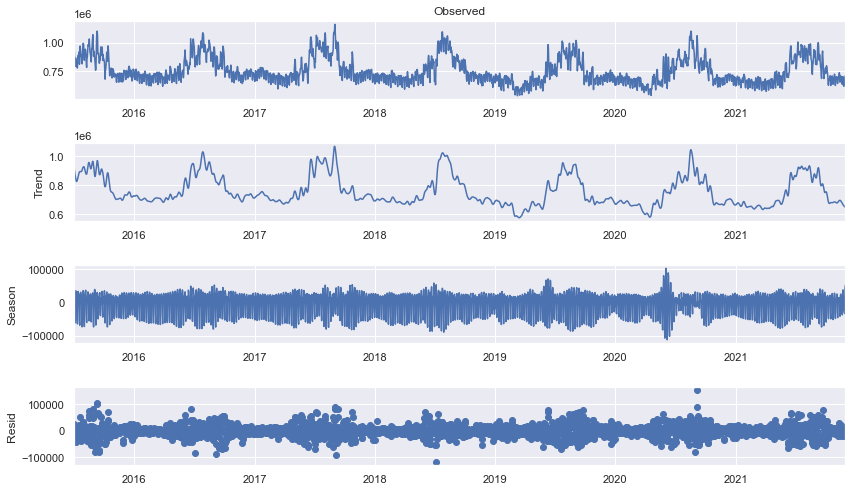

In [7]:
sns.set(rc={'figure.figsize':(12, 7)})

stl = STL(datos_diarios)
res = stl.fit()
fig = res.plot()

Grafiquemos la serie temporal mediante el comando *plot*.

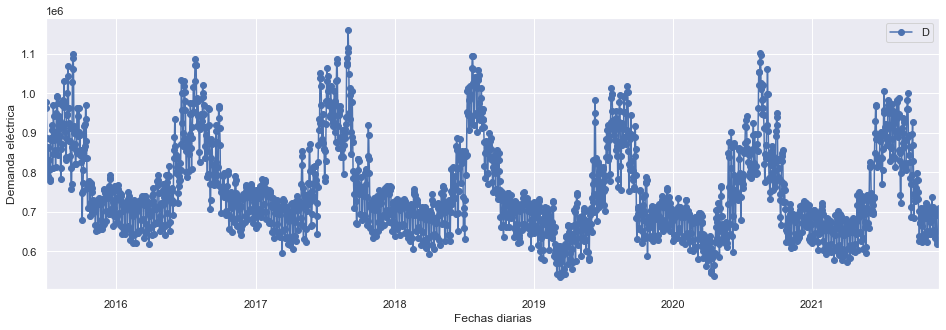

In [8]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_diarios.plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

Debido a que la serie se comporta de manera muy parecida año tras año, vamos a considerar los datos a partir de 2017 con el fin de reducir el número de datos.

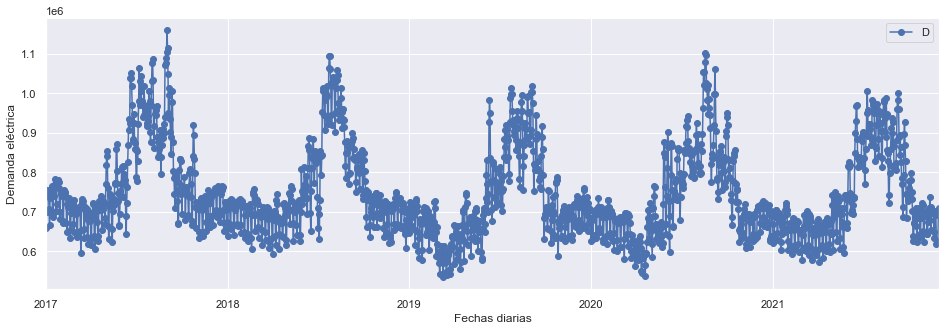

In [9]:
sns.set(rc = {"figure.figsize":(16,5)}) # Definimos el tamaño de la imagen
ax = datos_diarios["2017":].plot(marker = 'o', linestyle = '-')
ax.set_ylabel("Demanda eléctrica") # Añadimos título al eje y 
ax.set_xlabel("Fechas diarias"); # Añadimos título al eje x

#### ¿ESTACIONALIDAD MENSUAL, SEMANAL O TRIMESTRAL?

##### MENSUAL

Veamos una representación gráfica (mediante boxplots) de la distribución de los datos diarios por cada mes.

Para ello crearemos un nuevo data frame que será una copia del data frame *datos_diarios*. Calcularemos una nueva columna que será *mes* en este caso en el que indicará a qué mes pertenece cada dato. Después, calculamos para cada mes el boxplot de todos sus datos y finalmente graficamos el resultado.

In [10]:
datos_diarios_new = datos_diarios[:]

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7738/2361647250.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_diarios_new["mes"] = datos_diarios_new.index.month


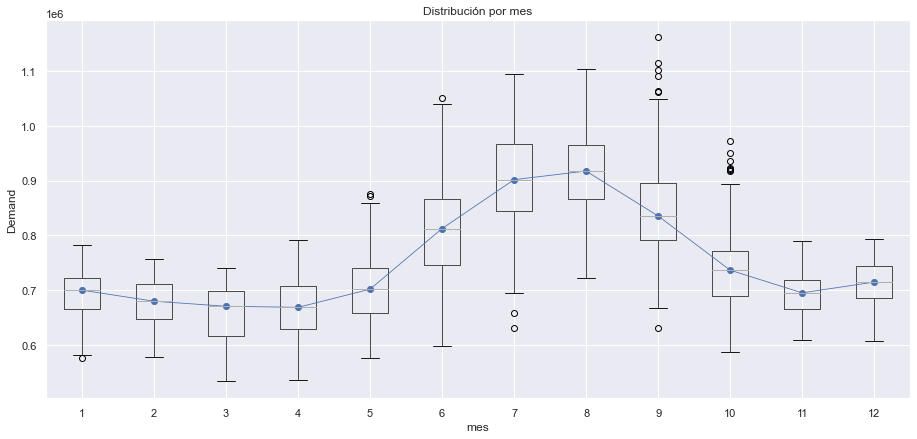

In [11]:
fig, ax = plt.subplots(figsize = (15, 7))
datos_diarios_new["mes"] = datos_diarios_new.index.month 
datos_diarios_new.boxplot(column="D", by="mes", ax=ax)
datos_diarios_new.groupby("mes")["D"].median().plot(style="-o", linewidth=0.8, ax=ax)
ax.set_ylabel("Demand")
ax.set_title("Distribución por mes")
fig.suptitle("");
plt.savefig("Images/Tendencia_mensual_datos_diarios.png", dpi=300, bbox_inches='tight')

Parece que la demanda eléctrica tiene un crecimiento en los meses de verano con respecto a los demás meses. Luego, claramente podemos decir que existe una componente estacional mensual en los datos diarios.

##### TRIMESTRAL

Veamos una representación gráfica (mediante boxplots) de la distribución de los datos diarios por cada trimestre de igual forma que hemos hecho para la estacionalidad mensual pero, en este caso, considerando estacionalidad trimestral

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7738/4242283604.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_diarios_new["trimestre"] = datos_diarios_new.index.quarter


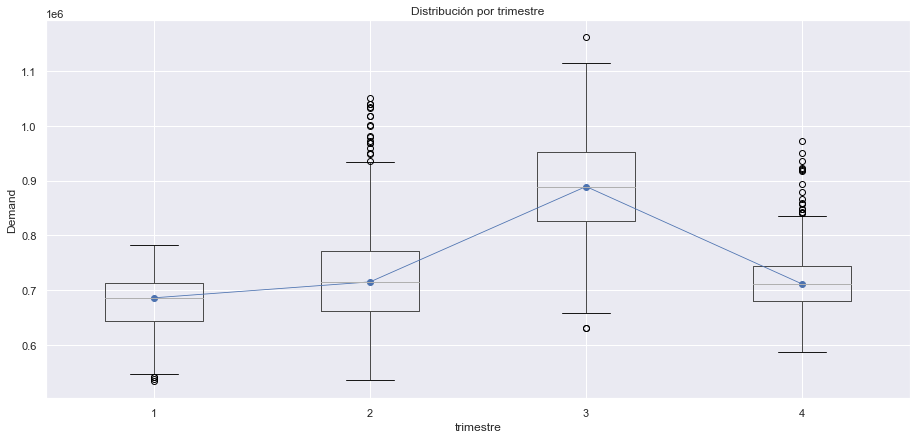

In [12]:
fig, ax = plt.subplots(figsize = (15, 7))
datos_diarios_new["trimestre"] = datos_diarios_new.index.quarter
datos_diarios_new.boxplot(column="D", by="trimestre", ax=ax)
datos_diarios_new.groupby("trimestre")["D"].median().plot(style="-o", linewidth=0.8, ax=ax)
ax.set_ylabel("Demand")
ax.set_title("Distribución por trimestre")
fig.suptitle("");
plt.savefig("Images/Tendencia_trimestral_datos_diarios.png", dpi=300, bbox_inches='tight')

Claramente observamos como el mayor consumo de energía se da en el tercer trimestre, es decir, en los meses de julio, agosto y septiembre. Estos meses son los más calurosos en la región de California y es por ello que la demanda sube, entre otros, por el uso del aire acondicionado.

##### SEMANAL

Veamos una representación gráfica (mediante boxplots) de la distribución de los datos diarios por cada semana.

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7738/1984985112.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_diarios_new["semana"] = datos_diarios_new.index.weekday + 1


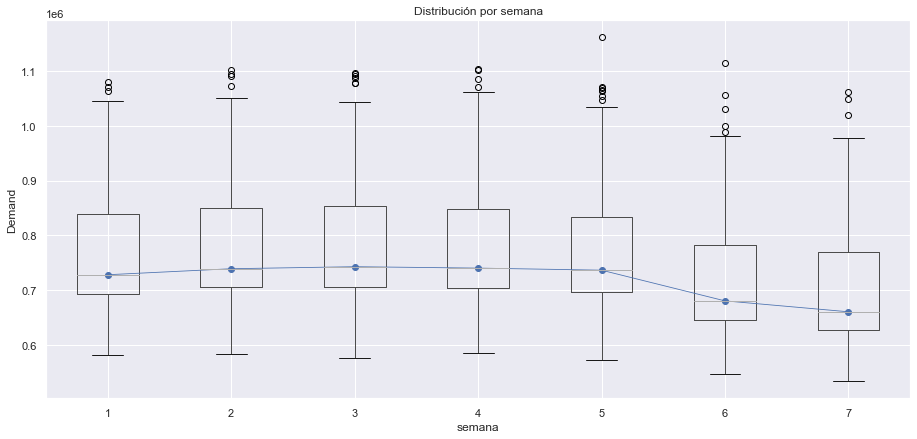

In [13]:
fig, ax = plt.subplots(figsize = (15, 7))
datos_diarios_new["semana"] = datos_diarios_new.index.weekday + 1
datos_diarios_new.boxplot(column="D", by="semana", ax=ax)
datos_diarios_new.groupby("semana")["D"].median().plot(style="-o", linewidth=0.8, ax=ax)
ax.set_ylabel("Demand")
ax.set_title("Distribución por semana")
fig.suptitle("");
plt.savefig("Images/Tendencia_semanal_datos_diarios.png", dpi=300, bbox_inches='tight')

En esta ocasión, podemos ver que la demanda de energía disminuye los fines de semana. Pero no observamos la misma componente estacional clara que observábamos con la componente estacional mensual.

### ELECCIÓN DE DATOS

Como hemos mencionado anteriormente, tomaremos los datos horarios a partir del año 2017 en adelante. De esta forma disminuimos la cantidad de datos y, además, únicamente seleccionamos aquellos datos utilizados para la modificación de los datos horarios en el notebook 01.

In [14]:
datos_diarios_d_2017 = datos_diarios["2017":].to_period("D")

Separamos en conjunto de training y testing dejando un mes en el conjunto de testing.

Las dimensiones del dataset de training es: 1765 y 30


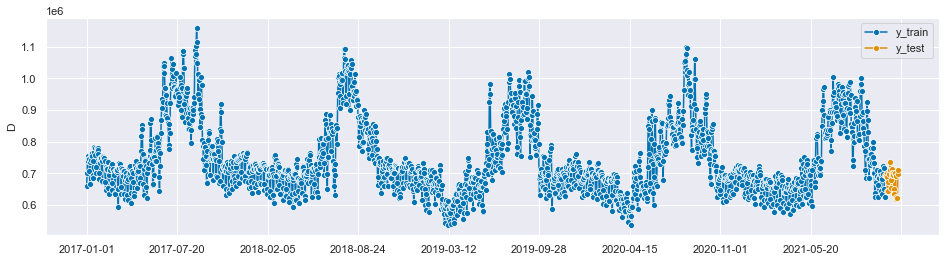

In [15]:
y_train_diario, y_test_diario = temporal_train_test_split(y = datos_diarios_d_2017["D"].astype('float64'), test_size=30)
plot_series(y_train_diario, y_test_diario, labels=["y_train", "y_test"])
print("Las dimensiones del dataset de training es:" ,y_train_diario.shape[0], "y", y_test_diario.shape[0])

### MODELO BASE

El modelo base del que haremos uso será el método ingenuo (Naive). Este método es utilizado en series temporales con componente estacional. Sencillamente, si por ejemplo queremos predecir datos trimestrales, la predicción del trimestre que queramos predecir tomará el valor del trimestre anterior. 

Definimos el horizonte de predicción.

In [16]:
fh = np.arange(1, 31)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='D'>)

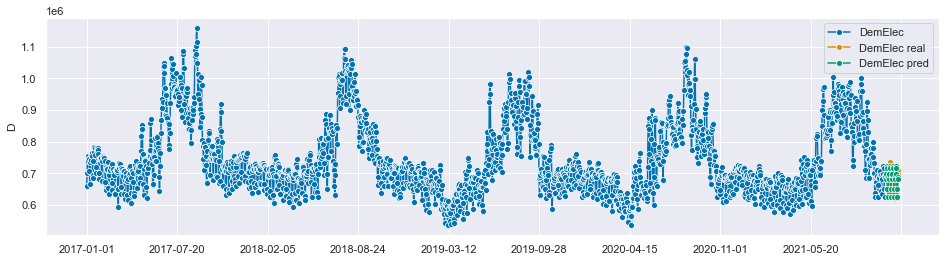

In [17]:
Met_Naive = NaiveForecaster(strategy="last", sp=7)

Met_Naive.fit(y_train_diario)

pred_Naive = Met_Naive.predict(fh)

plot_series(y_train_diario, y_test_diario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])


Veamos la comparación de la predicción y el conjunto de test.

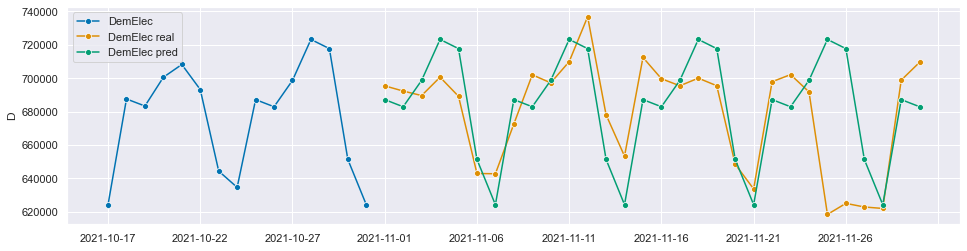

In [18]:
plot_series(y_train_diario[1750:], y_test_diario, pred_Naive, labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/Naive_datos_diarios.png", dpi=300, bbox_inches='tight')

La predicción, a simple vista, no es nada mala. Hay días que no detecta correctamente pero, desde ya podemos intuir un bajo valor en las métricas de error. Confirmemos esto calculando dichas métricas.

#### MÉTRICAS

In [19]:
MAPE_NAIVE = mean_absolute_percentage_error(y_test_diario, pred_Naive)
MAPE_NAIVE

0.031134496851259533

In [20]:
rmse_NAIVE = MeanSquaredError(square_root=True)
rmse_NAIVE =rmse_NAIVE(y_test_diario, pred_Naive)
rmse_NAIVE

30805.453411693197

In [21]:
r2_NAIVE = r2_score(y_test_diario, pred_Naive)
r2_NAIVE

0.06552306298671862

Este será nuestro modelo base y, a partir de aquí, todos los modelos que vayamos considerando deberán mejorar los resultados que acabamos de obtener.

## MODELO ETS

El modelo ETS es un modelo de descomposición. En función de la tendencia y la estacionalidad existen 15 tipos de modelos ETS. Nosotros haremos uso de la función AutoETS para que nos detecte, directamente, cuál es el mejor de los modelos en función de su AIC.

In [22]:
ETS_diario = AutoETS(auto=True, sp=7, n_jobs=-1) 

Entrenamos el modelo y mostramos un resumen de los resultados.

In [23]:
ETS_diario.fit(y_train_diario)
print(ETS_diario.summary())

                                 ETS Results                                  
Dep. Variable:                      D   No. Observations:                 1765
Model:                       ETS(MNM)   Log Likelihood              -20445.215
Date:                Fri, 21 Jan 2022   AIC                          40912.431
Time:                        14:35:43   BIC                          40972.666
Sample:                    01-01-2017   HQIC                         40934.688
                         - 10-31-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.028     35.340      0.000       0.944       1.055
smoothing_seasonal  5.476e-05        nan        nan        nan         nan         nan
initial_level       

Ahora calculamos las predicciones del modelo en nuestro horizonte de predicción.

In [24]:
ETS_diario_pred = ETS_diario.predict(fh)

Finalmente mostramos, gráficamente el resultado de las predicciones junto con el conjunto de test para poder comprobar el rendimiento del modelo. Lo haremos con la función plot_series() la cual nos permite graficar varias series temporales a la vez.

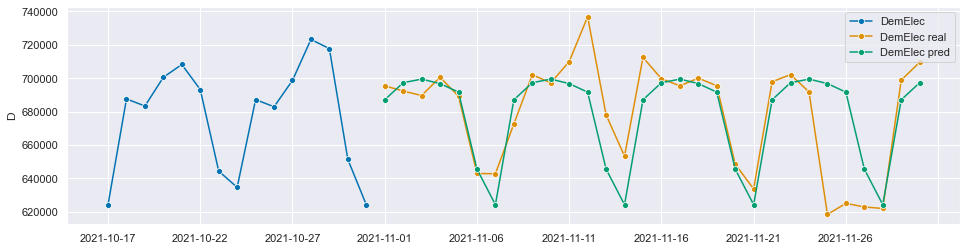

In [25]:
plot_series(y_train_diario[1750:], y_test_diario, ETS_diario_pred, labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/ETS_datos_diarios.png", dpi=300, bbox_inches='tight')

Los resultados obtenidos son realmente buenos. Confirmémoslo calculando los residuos y los posteriores valores de las métricas.

#### RESIDUOS

Para poder calcular los residuos crearemos un data frame con tres columnas. La primera de ellas se corresponderá con los valores predichos, la segunda con los valores reales y la tercera con los residuos, esto es, la diferencia entre los valores reales y los valores predichos. Calculamos dicho data frame a continuación y, después lo mostramos para ver su aspecto.

In [26]:
residuals_ETS_df = pd.DataFrame(ETS_diario_pred, columns=["D"])
residuals_ETS_df["real_D"] = y_test_diario
residuals_ETS_df["residuals"] = residuals_ETS_df["real_D"]-residuals_ETS_df["D"]
residuals_ETS_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_ETS_df

,predicted_D,real_D,residuals
2021-11-01,687068.992489,695421.0,8352.007511
2021-11-02,697294.916967,692311.0,-4983.916967
2021-11-03,699453.875251,689608.0,-9845.875251
2021-11-04,696765.783318,700606.0,3840.216682
2021-11-05,691645.261576,689165.0,-2480.261576
2021-11-06,645594.936232,642959.0,-2635.936232
2021-11-07,624261.252325,642785.0,18523.747675
2021-11-08,687068.992489,672601.0,-14467.992489
2021-11-09,697294.916967,702036.0,4741.083033
2021-11-10,699453.875251,697199.0,-2254.875251


Veamos ahora gráficamente estos residuos con la función plot_series().

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

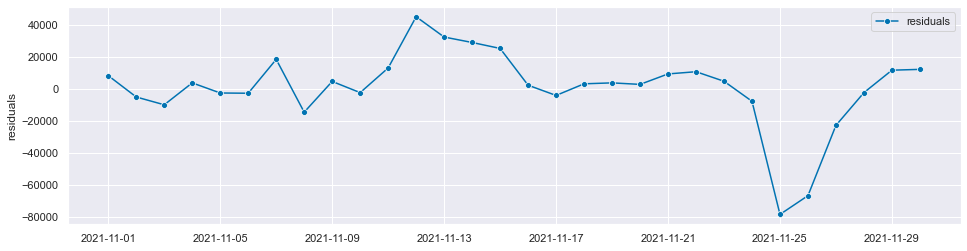

In [27]:
plot_series(residuals_ETS_df["residuals"], labels=["residuals"])

Calculamos la media de los residuos.

In [28]:
np.mean(residuals_ETS_df["residuals"])

798.7005970635219

Con la gráfica no sonseguimos determinar si los residuos son del todo buenos o no, para ello necesitamos atender a las métricas. Lo que si podemos observar es que la media está cerca de 800 el cual no es un valor muy alejado del 0.

#### MÉTRICAS

In [29]:
MAPE_ETS = mean_absolute_percentage_error(y_test_diario, ETS_diario_pred)
MAPE_ETS

0.022875438824523555

In [30]:
rmse_ETS = MeanSquaredError(square_root=True)
rmse_ETS = rmse_ETS(y_test_diario, ETS_diario_pred)
rmse_ETS

23995.939284125383

In [31]:
r2_ETS = r2_score(y_test_diario, ETS_diario_pred)
r2_ETS

0.4329923929691928

Las métricas son realmente buenas y mejoran nuestro modelo base.

## MODELO ARIMA

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
print(adfuller(datos_diarios_d_2017["D"])[1])

0.025008971268295068


In [34]:
from sktime.transformations.series.boxcox import LogTransformer
transformer = LogTransformer()
log_DemElec = transformer.fit_transform(datos_diarios_d_2017)
log_DemElec.tail()

,D
2021-11-26,13.345590
2021-11-27,13.342128
2021-11-28,13.340723
2021-11-29,13.457164
2021-11-30,13.472412


Graficamos la serie logaritmica.

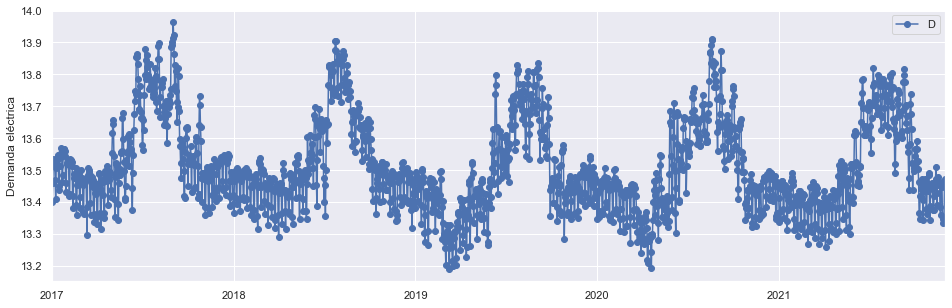

In [35]:
sns.set(rc = {"figure.figsize":(16,5)})
ax = log_DemElec.plot(marker = 'o', linestyle='-')
ax.set_ylabel('Demanda eléctrica');

Parece que después de aplicar el logaritmo, el problema de estacionariedad en media ha desaparecido. Vemos ahora el gráfico de correlaciones.

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

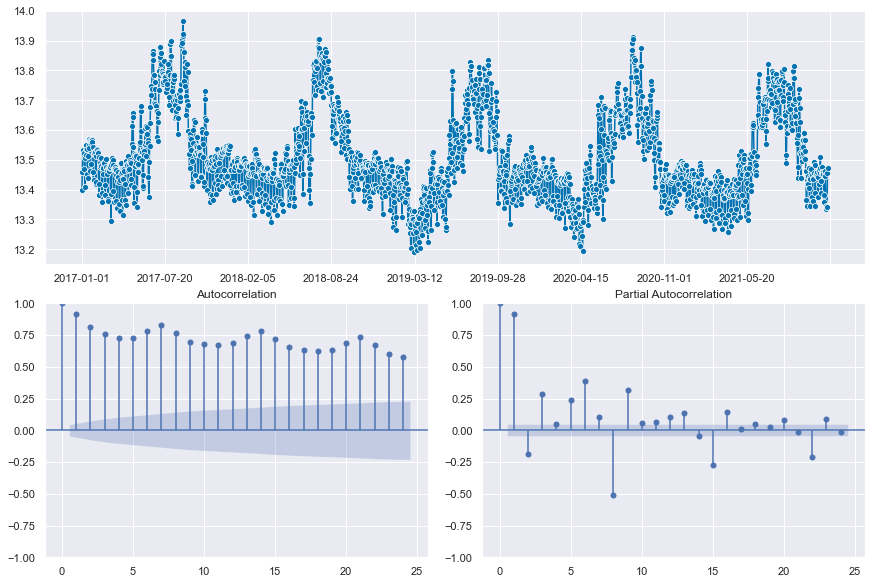

In [36]:
plot_correlations(log_DemElec)

Vemos que todavía nuestra serie logarítmica no es estacionaria, luego tiene la misma importancia la historia cercana que la lejana. Calcularemos la función AutoARIMA la cual se encargará de tomar diferencias y conseguir que la serie sea estacionaria. Pero antes, deberemos separar en train y test la serie logarítmica mediante la función temporal_train_test_split().

In [37]:
log_y_train, log_y_test = temporal_train_test_split(y = log_DemElec, test_size=30)

Ahora si podemos calcular el AutoARIMA y entrenarlo.

In [38]:
ARIMA_diario = AutoARIMA(sp=7, suppress_warnings=True)

ARIMA_diario.fit(log_y_train)

AutoARIMA(sp=7, suppress_warnings=True)

In [39]:
print(ARIMA_diario.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1765
Model:             SARIMAX(1, 0, 2)x(2, 0, 2, 7)   Log Likelihood                3441.289
Date:                           Fri, 21 Jan 2022   AIC                          -6864.579
Time:                                   14:37:40   BIC                          -6815.296
Sample:                                        0   HQIC                         -6846.368
                                          - 1765                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.001e-05   1.24e-05      0.808      0.419   -1.43e-05    3.43e-05
ar.L1          0.9395      0.011     88.860

In [40]:
log_y_pred_ARIMA = ARIMA_diario.predict(fh)

Mediante la exponencial deshacemos el cambio logarítmico.

In [41]:
np.exp(log_y_pred_ARIMA)

,D
2021-11-01,683686.701459
2021-11-02,695353.676068
2021-11-03,703121.250713
2021-11-04,711334.782816
2021-11-05,710679.424621
2021-11-06,665191.423604
2021-11-07,645260.205715
2021-11-08,708230.283222
2021-11-09,720818.203425
2021-11-10,727140.480499


Mostramos los resultados obtenidos gráficamente

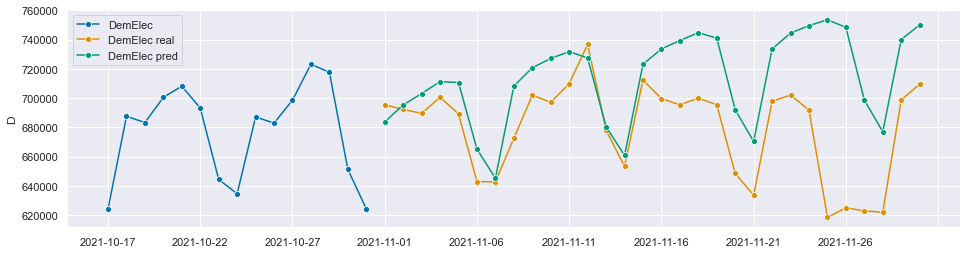

In [42]:
plot_series(y_train_diario[1750:], y_test_diario,  np.exp(log_y_pred_ARIMA), labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/ARIMA_datos_diarios.png", dpi=300, bbox_inches='tight')

Observamos que los resultados no son muy buenos ya que la predicción del ARIMA al principio detecta bien los valores del test pero, a partir del día 14 de noviembre existe una diferencia muy grande.

#### RESIDUOS

En primer lugar calculamos los residuos manualmente en un data frame. Lo haremos considerando el data frame de la predicción y le introduciremos los datos reales y, después calcularemos una nueva columna que serán los residuos.

In [43]:
residuals_ARIMA_df = np.exp(log_y_pred_ARIMA)
residuals_ARIMA_df["real_D"] = y_test_diario
residuals_ARIMA_df["residuals"] = residuals_ARIMA_df["real_D"]-residuals_ARIMA_df["D"]
residuals_ARIMA_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_ARIMA_df

,predicted_D,real_D,residuals
2021-11-01,683686.701459,695421.0,11734.298541
2021-11-02,695353.676068,692311.0,-3042.676068
2021-11-03,703121.250713,689608.0,-13513.250713
2021-11-04,711334.782816,700606.0,-10728.782816
2021-11-05,710679.424621,689165.0,-21514.424621
2021-11-06,665191.423604,642959.0,-22232.423604
2021-11-07,645260.205715,642785.0,-2475.205715
2021-11-08,708230.283222,672601.0,-35629.283222
2021-11-09,720818.203425,702036.0,-18782.203425
2021-11-10,727140.480499,697199.0,-29941.480499


Mostremos ahora una gráfica en la que veremos la evolución de los residuos.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

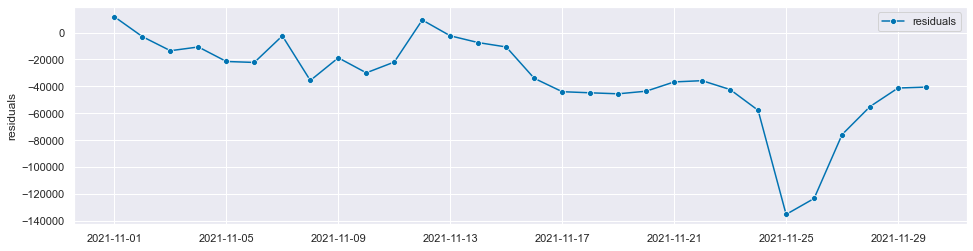

In [44]:
plot_series(residuals_ARIMA_df["residuals"], labels=["residuals"])

Se puede comprobar que los residuos son muy grandes. Verifiquemos esto con el cálculo de las diferentes métricas.

#### MÉTRICAS

In [45]:
MAPE_ARIMA = mean_absolute_percentage_error(y_test_diario, np.exp(log_y_pred_ARIMA))
MAPE_ARIMA

0.05169882614716346

In [46]:
rmse_ARIMA = MeanSquaredError(square_root=True)
rmse_ARIMA = rmse_ARIMA(y_test_diario, np.exp(log_y_pred_ARIMA))
rmse_ARIMA

47299.94193263633

In [47]:
r2_ARIMA = r2_score(y_test_diario, np.exp(log_y_pred_ARIMA))
r2_ARIMA

-1.203101934627297

El hecho de obtener un r^2 negativo no nos genera buenas sensaciones ya que eso significa que el modelo es malo.

## MODELO PROPHET

Prophet es un método para predicción de series temporales creado por Facebook. Este método utiliza un modelo de descomposición con tres componentes principales: tendencia, estacionalidad, y vacaciones. Para poder hacer uso de la librería Prophet deberemos tener un data frame con dos columnas. La primera indicará la fecha y se llamará *ds* y la segunda indicará la demanda y se llamará *y*.

Luego, deberemos considerar los datos a partir de 2017 y modificar el df de tal forma que lo tengamos como nos indica la librería Prophet

In [48]:
y = datos_diarios["2017":].reset_index(drop=False)
y.columns = ["ds", "y"]
y.tail()

,ds,y
1790,2021-11-26,625052
1791,2021-11-27,622892
1792,2021-11-28,622017
1793,2021-11-29,698831
1794,2021-11-30,709568


Separamos en train y test teniendo en cuenta que tenemos 1765 datos de training.

In [49]:
train = y.iloc[:1765,:]
test = y.iloc[1765:,:]

Definimos y entrenamos el modelo Prophet.

In [50]:
m = Prophet()
m.fit(train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.5634


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       4722.13    0.00426071       229.871           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       4723.24    1.4433e-06       74.7473      0.6777      0.6777      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       4723.28   9.15543e-05       150.294   9.281e-07       0.001      343  LS failed, Hessian reset 
     244       4723.31   2.58922e-07       54.6699       0.102           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Calculamos las predicciones con frecuencia diaria.

In [51]:
future = m.make_future_dataframe(periods=len(test), freq="D")
forecast = m.predict(future)

Creamos un nuevo data frame para las predicciones que nos permita tener el mismo índice que el conjunto de test. Esto lo hacemos para poder graficar el conjunto de test junto con las predicciones en la función plot_series().

In [52]:
forecast_new = forecast[:]
forecast_new.index = datos_diarios_d_2017.index
forecast_new = forecast_new[["yhat"]]
forecast_new.index

PeriodIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
             '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
             '2017-01-09', '2017-01-10',
             ...
             '2021-11-21', '2021-11-22', '2021-11-23', '2021-11-24',
             '2021-11-25', '2021-11-26', '2021-11-27', '2021-11-28',
             '2021-11-29', '2021-11-30'],
            dtype='period[D]', length=1795)

Finalmente mostramos los resultados gráficos de nuestro modelo Prophet.

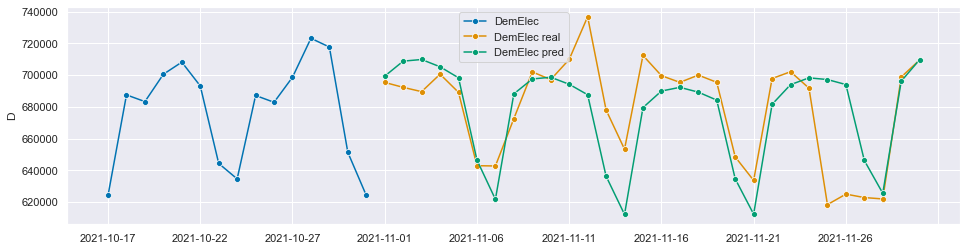

In [53]:
plot_series(y_train_diario[1750:], y_test_diario, forecast_new[1765:], labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/PROPHET_datos_diarios.png", dpi=300, bbox_inches='tight')

Una vez visto el rendimiento gráfico de nuestro modelo, pasemos a ver el rendimiento numérico del modelo Prophet, calculando los residuos y los valores de las métricas

#### RESIDUOS

In [54]:
forecast_new = forecast[:]

In [55]:
forecast_new.index = forecast["ds"]
residuals_PROPHET_df = forecast[["yhat"]][1765:]
residuals_PROPHET_df["real_D"] = np.array(y_test_diario)
residuals_PROPHET_df["residuals"] = residuals_PROPHET_df["real_D"]-residuals_PROPHET_df["yhat"]
residuals_PROPHET_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_PROPHET_df

,predicted_D,real_D,residuals
1765,699361.051013,695421.0,-3940.051013
1766,708819.347855,692311.0,-16508.347855
1767,709859.837373,689608.0,-20251.837373
1768,705258.634472,700606.0,-4652.634472
1769,698336.228782,689165.0,-9171.228782
1770,646529.308573,642959.0,-3570.308573
1771,621778.390656,642785.0,21006.609344
1772,688200.151206,672601.0,-15599.151206
1773,697592.743004,702036.0,4443.256996
1774,698677.407183,697199.0,-1478.407183


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

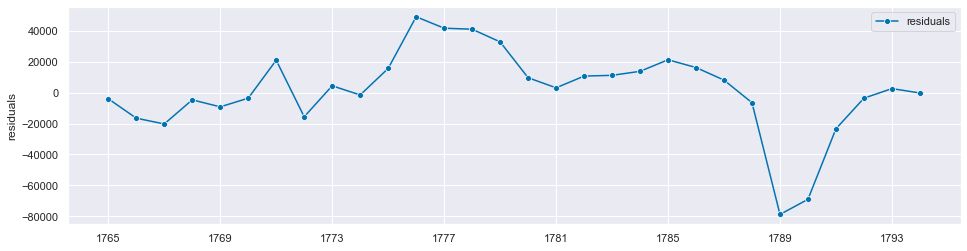

In [56]:
plot_series(residuals_PROPHET_df["residuals"], labels=["residuals"])

Veamos las métricas para poder tener una aproximación numérica sobre el rendimiento del modelo.

#### MÉTRICAS

In [57]:
MAPE_PROPHET = mean_absolute_percentage_error(test["y"], forecast.loc[1765:,'yhat'])
MAPE_PROPHET

0.027882450995852927

In [58]:
rmse_PROPHET = MeanSquaredError(square_root=True)
rmse_PROPHET = rmse_PROPHET(test["y"], forecast.loc[1765:,'yhat'])
rmse_PROPHET

26824.615827890386

In [59]:
r2_PROPHET = r2_score(list(test['y']), list(forecast.loc[1765:,'yhat']))
r2_PROPHET

0.2914338544001158

## MODELO AMAZON DEEPAR

Tomamos el dataset creado para utilizar Prophet y le modificamos el nombre de las columnas, pues la librería gluonts trabaja con una columna "date" y una columna "y".

In [60]:
y.columns=["date", "y"]

Ahora debemos separar en train y test. Los conjuntos de training y testing los llamaremos train_ds y test_ds respectivamente. El conjunto de training debe contener 1765 datos y el conjunto de testing debe contener 30 datos.

In [61]:
from gluonts.dataset.common import ListDataset
start = pd.Timestamp("2017-01-01", freq="D")
# train dataset: cut the last window of length "prediction_length", add "target" and "start" fields
train_ds = ListDataset([{'target': y.loc[:1765,'y'], 'start': start}], freq='D')
# test dataset: use the whole dataset, add "target" and "start" fields
test_ds = ListDataset([{'target': y['y'], 'start': start}],freq='D')

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7738/2153226456.py:2: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  start = pd.Timestamp("2017-01-01", freq="D")


Visualicemos ahora los conjuntos de train y test obtenidos

In [62]:
train_ds.list_data

[{'target': 0       659836
  1       699639
  2       754108
  3       744807
  4       738782
           ...  
  1761    723206
  1762    717705
  1763    651362
  1764    624261
  1765    695421
  Name: y, Length: 1766, dtype: int64,
  'start': Timestamp('2017-01-01 00:00:00', freq='D')}]

In [63]:
test_ds.list_data

[{'target': 0       659836
  1       699639
  2       754108
  3       744807
  4       738782
           ...  
  1790    625052
  1791    622892
  1792    622017
  1793    698831
  1794    709568
  Name: y, Length: 1795, dtype: int64,
  'start': Timestamp('2017-01-01 00:00:00', freq='D')}]

Ahora deberemos crear y entrenar nuestro modelo.

In [64]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    prediction_length=30,
    context_length=100,
    freq='D',
    trainer=Trainer(epochs=20,
                    learning_rate=1e-2,
                    num_batches_per_epoch=60)
)

predictor = estimator.train(train_ds)

INFO:gluonts.mx.context:Using CPU
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:323: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(string, freq=freq)
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:326: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if isinstance(timestamp.freq, Tick):
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:328: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  timestamp.floor(timestamp.freq), timestamp.freq
/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/dataset/common.py:327: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  return pd.Timestamp(
/Users

In [65]:
predictions = predictor.predict(test_ds)
predictions = list(predictions)[0]
predictions = predictions.quantile(0.5)

/Users/aitor/opt/anaconda3/envs/ML_big_practice/lib/python3.9/site-packages/gluonts/transform/feature.py:352: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  self._min_time_point, self._max_time_point, freq=start.freq


Visualicemos la variable predictions.

In [66]:
predictions

array([693653.75, 675923.56, 679440.3 , 642303.9 , 630402.  , 694746.75,
       701023.44, 705542.2 , 700272.3 , 700442.4 , 661871.9 , 649427.75,
       704317.9 , 701606.6 , 707074.44, 701428.06, 695555.3 , 658475.  ,
       647040.7 , 694719.7 , 699161.6 , 699739.1 , 690767.  , 680048.44,
       653320.06, 646068.5 , 692222.9 , 688138.94, 691114.56, 685673.  ],
      dtype=float32)

Debemos crear un data frame con los datos de las predicciones que acabamos de obtener y, en su índice, las fechas del conjunto de testing. Esto lo hacemos para poder hacer uso de la función plot_series la cual nos permite visualizar dos o más series al mismo tiempo, pero los índices de ambas series deben ser iguales y del mismo tamaño. Por eso igualamos el índice de nuestro data frame al índice del conjunto de testing.

In [67]:
pred = pd.DataFrame(predictions, columns=["D"])
pred.index = y_test_diario.index

Visualicemos ahora ambas series.

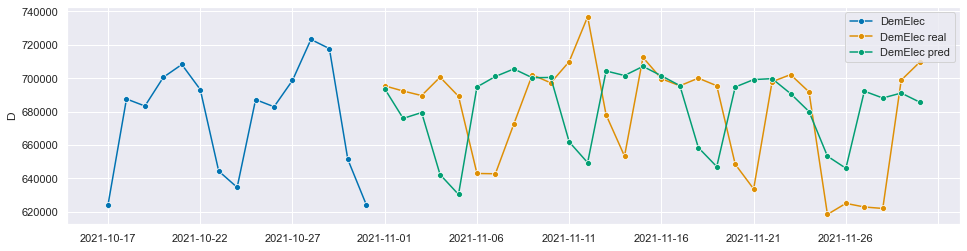

In [68]:
plot_series(y_train_diario[1750:], y_test_diario, pred, labels=["DemElec", "DemElec real", "DemElec pred"])
plt.savefig("Images/DEEPAR_datos_diarios.png", dpi=300, bbox_inches='tight')

Parece que la predicción no se escapa mucho de la serie real, pero tampoco acierta demasiado bien. Hallemos las métricas para tener una idea numérica de la aproximación de nuestra predicción.

#### RESIDUOS

Repetimos el mismo proceso que en anteriores modelos para poder llevar a cabo el cálculo de los residuos.

In [69]:
residuals_DEEPAR_df = pred[:]
residuals_DEEPAR_df["real_D"] = np.array(y_test_diario)
residuals_DEEPAR_df["residuals"] = residuals_DEEPAR_df["real_D"]-residuals_DEEPAR_df["D"]
residuals_DEEPAR_df.columns = ["predicted_D", "real_D", "residuals"]
residuals_DEEPAR_df

/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7738/3697269814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_DEEPAR_df["real_D"] = np.array(y_test_diario)
/var/folders/3q/zfn8yb513nj10ry8w8r8_jmc0000gn/T/ipykernel_7738/3697269814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  residuals_DEEPAR_df["residuals"] = residuals_DEEPAR_df["real_D"]-residuals_DEEPAR_df["D"]


,predicted_D,real_D,residuals
2021-11-01,693653.7500,695421.0,1767.2500
2021-11-02,675923.5625,692311.0,16387.4375
2021-11-03,679440.3125,689608.0,10167.6875
2021-11-04,642303.8750,700606.0,58302.1250
2021-11-05,630402.0000,689165.0,58763.0000
2021-11-06,694746.7500,642959.0,-51787.7500
2021-11-07,701023.4375,642785.0,-58238.4375
2021-11-08,705542.1875,672601.0,-32941.1875
2021-11-09,700272.3125,702036.0,1763.6875
2021-11-10,700442.3750,697199.0,-3243.3750


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

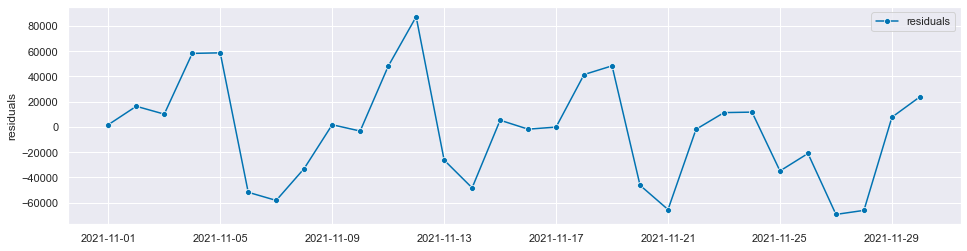

In [70]:
plot_series(residuals_DEEPAR_df["residuals"], labels=["residuals"])

Vemos que los valores obtenidos en los residuos son realmente malos. Veamos qué ocurre con las métricas

#### MÉTRICAS

In [71]:
MAPE_DEEPAR = mean_absolute_percentage_error(y_test_diario, pred)
MAPE_DEEPAR

0.04760074932700283

In [72]:
rmse_DEEPAR = MeanSquaredError(square_root=True)
rmse_DEEPAR = rmse_DEEPAR(y_test_diario, pred)
rmse_DEEPAR

40672.118445381675

In [73]:
r2_DEEPAR = r2_score(y_test_diario, pred)
r2_DEEPAR

-0.6289470366376284

### RESUMEN MÉTRICAS DE TODOS LOS MODELOS

In [74]:
MAPE = [MAPE_NAIVE, MAPE_ETS, MAPE_ARIMA, MAPE_PROPHET, MAPE_DEEPAR]
RMSE = [rmse_NAIVE, rmse_ETS, rmse_ARIMA, rmse_PROPHET, rmse_DEEPAR]
R2 = [r2_NAIVE, r2_ETS, r2_ARIMA, r2_PROPHET, r2_DEEPAR]
data = {"MAPE": MAPE, "RMSE":RMSE, "R2":R2}
df_metricas = pd.DataFrame(data, columns=["MAPE", "RMSE", "R2"])
df_metricas.index=["Naive", "ETS", "ARIMA", "Prophet", "DEEPAR"]
df_metricas

,MAPE,RMSE,R2
Naive,0.031134,30805.453412,0.065523
ETS,0.022875,23995.939284,0.432992
ARIMA,0.051699,47299.941933,-1.203102
Prophet,0.027882,26824.615828,0.291434
DEEPAR,0.047601,40672.118445,-0.628947


Descartamos los modelo DeepAR y ARIMA por su mal rendimiento. Además, generan peores resultados que nuestro modelo base. Parece que el mejor de los modelos es el ETS. Veamos la comparación de residuos

#### RESIDUOS

Primeramente debemos tener los índices de todos los data frames en el mismo formato.

In [75]:
residuals_PROPHET_df["residuals"].index = residuals_ARIMA_df["residuals"].index

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

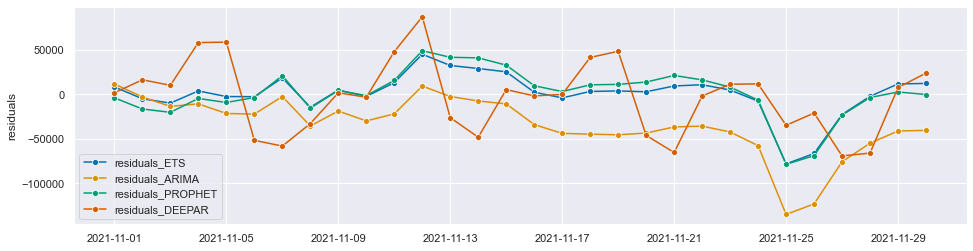

In [76]:
plot_series(residuals_ETS_df["residuals"], residuals_ARIMA_df["residuals"], residuals_PROPHET_df["residuals"], residuals_DEEPAR_df["residuals"],
            labels=["residuals_ETS", "residuals_ARIMA", "residuals_PROPHET", "residuals_DEEPAR"])

Descartamos el DEEPAR y analizamos los demás modelos.

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='residuals'>)

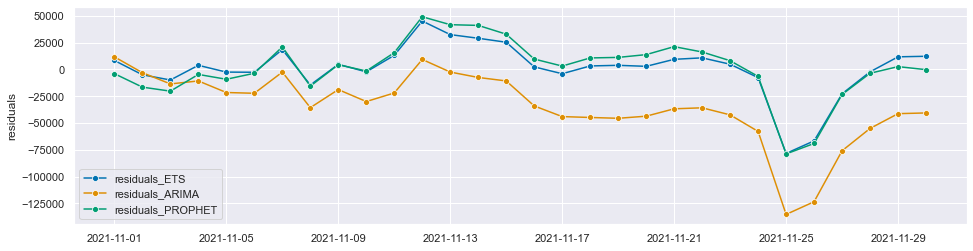

In [77]:
plot_series(residuals_ETS_df["residuals"], residuals_ARIMA_df["residuals"], residuals_PROPHET_df["residuals"], labels=["residuals_ETS", "residuals_ARIMA", "residuals_PROPHET"])

Vemos que tanto el modelo Prophet y el ETS tienen residuos muy parecidos, pero, analizando las métricas, concluimos que el mejor de los modelos es el ETS.

## PREDICCIÓN DE LOS PRIMEROS 15 DÍAS DE DICIEMBRE

La predicción de los primeros 15 días de diciembre con periodicidad diaria la haremos con el mejor de los modelos, es decir, con el modelo ETS. Para ello, lo primero que deberemos hacer será coger todos los datos como datos de training y después predecir en el nuevo horizonte de predicción de 15 días.

In [78]:
fh_new = np.arange(1,16)

In [79]:
ETS_diario_pred_final = AutoETS(auto=True, sp=7, n_jobs=-1) 

In [80]:
ETS_diario_pred_final.fit(datos_diarios_d_2017["D"].astype("float64"))
print(ETS_diario_pred_final.summary())

                                 ETS Results                                  
Dep. Variable:                      D   No. Observations:                 1795
Model:                       ETS(MNM)   Log Likelihood              -20786.052
Date:                Fri, 21 Jan 2022   AIC                          41594.105
Time:                        14:40:56   BIC                          41654.525
Sample:                    01-01-2017   HQIC                         41616.411
                         - 11-30-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.028     35.664      0.000       0.945       1.055
smoothing_seasonal  5.355e-05        nan        nan        nan         nan         nan
initial_level       

A continuación calculamos y mostramos la predicción para los primeros 15 días de diciembre.

In [81]:
ETS_diario_final_pred = ETS_diario_pred_final.predict(fh_new)
print(ETS_diario_final_pred)

2021-12-01    711623.407082
2021-12-02    708761.472502
2021-12-03    703691.661481
2021-12-04    656962.984146
2021-12-05    635419.641514
2021-12-06    699264.599244
2021-12-07    709567.979530
2021-12-08    711623.407082
2021-12-09    708761.472502
2021-12-10    703691.661481
2021-12-11    656962.984146
2021-12-12    635419.641514
2021-12-13    699264.599244
2021-12-14    709567.979530
2021-12-15    711623.407082
Freq: D, dtype: float64


A continuación mostramos, gráficamente, la predicción para los primeros 15 días de diciembre

In [82]:
plot_series(datos_diarios_d_2017["D"].astype("float64")[1794prediccion_horarias = pd.DataFrame(forecast_final["yhat"][1465:])
prediccion_horarias["date"] = prediccion_horarias.index
prediccion_horarias

Eliminamos el índice y nos quedamos únicamente con las 2 columnas para pasar a csv.

prediccion_horarias.to_csv("prediccion_final_horaria", sep=";", index=False):], ETS_diario_final_pred, labels=["DemElec", "DemElec pred"])
plt.savefig("Images/ETS_pred_diario.png", dpi=300, bbox_inches='tight')

SyntaxError: invalid syntax (1330365649.py, line 1)

In [ ]:
prediccion_diarias = pd.DataFrame(ETS_diario_final_pred)
prediccion_diarias["date"] = prediccion_diarias.index
prediccion_diarias.columns = ["D", "date"]

Eliminamos el índice y nos quedamos únicamente con las 2 columnas para pasar a csv.

In [ ]:
prediccion_diarias.to_csv("prediccion_final_diaria", sep=";", index=False)